In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
import matplotlib.pyplot as plt
from torch import Tensor
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
from torch_geometric.data import Data

In [2]:
from torch_geometric.datasets import WordNet18RR

dataset = WordNet18RR(root='data/WordNet18RR')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Possible types of edges: {torch.unique(data.edge_type).numpy()}')
edge_types = torch.unique(data.edge_type).numpy().shape[0]
print(f'Train edges: {data.train_mask.sum()}')
print(f'Validation edges: {data.val_mask.sum()}')
print(f'Test edges: {data.test_mask.sum()}')

Processing...
Done!



Dataset: WordNet18RR():
Number of graphs: 1
Number of features: 0
Number of classes: 0

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943)
Number of nodes: 40943
Number of edges: 93003
Average node degree: 2.27
Number of training nodes: 86835
Training node label rate: 2.12
Has isolated nodes: False
Has self-loops: True
Is undirected: False
Possible types of edges: [ 0  1  2  3  4  5  6  7  8  9 10]
Train edges: 86835
Validation edges: 3034
Test edges: 3134


In [3]:
# concatenate edge_index and edge_type in one tensor
triplets = torch.cat((data.edge_index[0], data.edge_type, data.edge_index[1])).reshape((3, -1))
triplets

tensor([[    0,     0,     1,  ..., 40933, 40934, 40935],
        [    3,     9,    10,  ...,     3,     3,     3],
        [10211, 25525,  3891,  ...,  8943,  8648,  6809]])

In [4]:
def triplets_by_mask(triplets: Tensor, mask: Tensor) -> Tensor:
  return triplets[:, torch.where(mask)[0].numpy()]

# split triples into train, validation and test
train_triplets = triplets_by_mask(triplets, data.train_mask)
val_triplets = triplets_by_mask(triplets, data.val_mask)
test_triplets = triplets_by_mask(triplets, data.test_mask)

train_triplets.shape, val_triplets.shape, test_triplets.shape

(torch.Size([3, 86835]), torch.Size([3, 3034]), torch.Size([3, 3134]))

In [5]:
from transe import TransE

model = TransE(
  k=20, 
  gamma=2, 
  num_nodes=data.num_nodes, 
  num_diff_edges=edge_types, 
  p=1
)

losses = []
val_losses = []

In [6]:
opt = torch.optim.Adam([model.ent_embs, model.rel_embs], lr=0.05)

In [7]:
epochs = 8000
batch_size = 4096

for epoch in tqdm(range(epochs)):

  # permutation for batch sampling
  permutation = torch.randperm(train_triplets.shape[1])

  for i in range(0, train_triplets.shape[1], batch_size):
    # sampling batch
    indices = permutation[i : i + batch_size]
    loss = model.loss(
        train_triplets[0, indices],
        train_triplets[1, indices],
        train_triplets[2, indices]
    ).sum()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item() / indices.shape[0])
  
  # calculating loss for validation dataset
  val_losses.append(model.loss(
      val_triplets[0], val_triplets[1], val_triplets[2]
  ).sum().item() / val_triplets.shape[1])

  0%|          | 0/8000 [00:00<?, ?it/s]

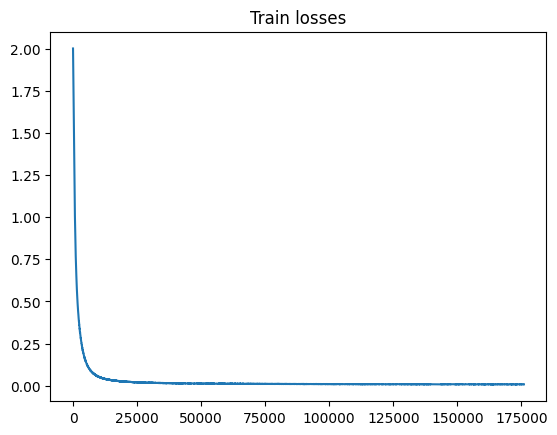

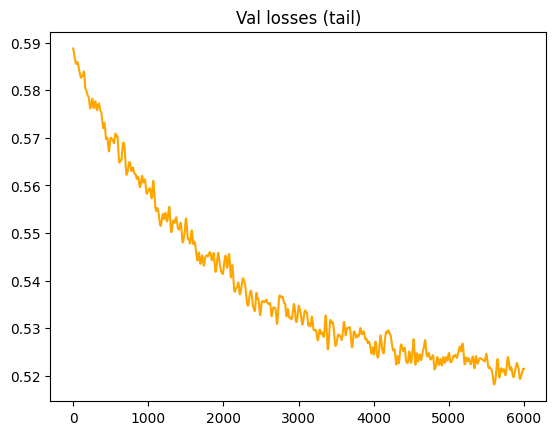

In [8]:
plt.plot(gaussian_filter1d(losses[:], 10))
plt.title("Train losses")
plt.show()
plt.plot(gaussian_filter1d(val_losses[2000:], 10), color='orange')
plt.title("Val losses (tail)")
plt.show()

In [9]:
from accuracy_utils import mean_accuracy

mr, hts10 = mean_accuracy(
    model.get_entities_embs(), 
    model.get_relations_embs(), 
    test_triplets, 
    p_norm=1
)
print("Mean rank:", mr)
print("Hits@10:", hts10)

Mean rank: 3902.8211550733886
Hits@10: 0.41448627951499684
